In [1]:
import shutil
import os

In [ ]:
os.makedirs('./all_images', exist_ok=True)

for fname in os.listdir('./ham10000_images_part_1'):
  shutil.copy(f'./ham10000_images_part_1/{fname}', './all_images/')

for fname in os.listdir('./ham10000_images_part_2'):
  shutil.copy(f'./ham10000_images_part_2/{fname}', './all_images/')

In [ ]:
import pandas as pd

# Read Metadata

df = pd.read_csv('HAM10000_metadata.csv')
df['path'] = df['image_id'].apply(lambda x: f'./all_images/{x}.jpg')

In [ ]:
# Create a Label Encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

In [ ]:
import torchvision.transforms as transforms

# Transform the data

training_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.RandomRotation(degrees=20),
  transforms.RandomResizedCrop(224,scale=(0.8, 1.0)),
  transforms.ColorJitter(brightness=0.1,contrast=0.1),
  transforms.ToTensor()
])

testing_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor()
])

In [ ]:
from PIL import Image
from torch.utils.data import Dataset

# Class to read and iterate over the data

class HAM10000Dataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)
  
  def __iter__(self):
    self.index = 0
    return self
  
  def __next__(self):
    if self.index >= len(self.df):
      raise StopIteration
    else:
      idx = self.index
      self.index += 1
      return self[idx]

  def __getitem__(self, idx):
    img_path = self.df.iloc[idx]['path']
    image = Image.open(img_path).convert('RGB')
    label = self.df.iloc[idx]['label']
    if self.transform:
      image = self.transform(image)
    return image, label

In [ ]:
from sklearn.model_selection import train_test_split

# 70, 15, 15 split of training, test, and validation data.

train_df, temp_df = train_test_split(df, stratify=df['label'], test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, stratify=temp_df['label'], test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_df, transform=training_transform)
val_dataset = HAM10000Dataset(val_df, transform=testing_transform)
test_dataset = HAM10000Dataset(test_df, transform=testing_transform)

In [8]:
print("Class distribution:")
print(df['dx'].value_counts())

Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


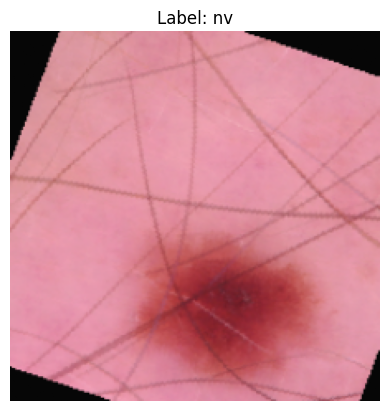

In [9]:
import matplotlib.pyplot as plt

sample_img, sample_label = train_dataset[0]

plt.imshow(sample_img.permute(1, 2, 0))
plt.title(f"Label: {label_encoder.inverse_transform([sample_label])[0]}")
plt.axis('off')
plt.show()

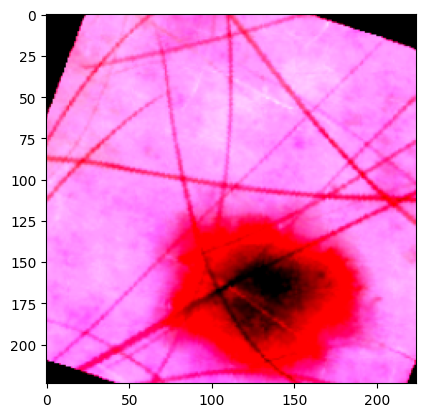

In [ ]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import numpy as np
from IPython.display import clear_output

# KNN Specific Work
# Using the ConvNeXt CNN Model, generate feature data for all the images in
# each dataset (training, test, validation). This done for each dataset one at a time.
# After that, flatten the vector and add it to an array (Each row is all the feature data for a given image)
# Also add the label to another array.

weights = ConvNeXt_Tiny_Weights.DEFAULT
model = convnext_tiny(weights=weights)
model.eval()
preprocess = weights.transforms()
features = np.zeros(shape=(len(test_dataset), 768*7*7))
labels = []
batch = preprocess(sample_img).unsqueeze(0)

sub_img = batch[0, :, :, :]
plt.imshow(sub_img.permute(1, 2, 0))

for i, (image, label) in enumerate(test_dataset):
    print(len(test_dataset) - i)
    batch = preprocess(image).unsqueeze(0)
    feat = model.features(batch)
    feat = feat[0, :, :, :]
    feat = feat.detach().reshape(-1, 768*7*7).numpy()
    features[i] = feat
    labels.append(label)
    clear_output()

In [ ]:
# Save the results in a dataframe along with the labels. Data Processing for KNN complete.
data = pd.DataFrame(features)
data["Labels"] = labels
data.to_parquet("testdata.parquet")
import pickle
np.savetxt("testfeatures.csv", features, delimiter=",")
with open("testfile.pkl", "xb") as f:
    pickle.dump(labels, f)

/home/kb/.local/lib/python3.13/site-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
